# Overview

## Description
Zillow’s Zestimate home valuation has shaken up the U.S. real estate industry since first released 11 years ago. The Zestimate was created to give consumers as much information as possible about homes and the housing market, marking the first time consumers had access to this type of home value information at no cost.

“Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. And, by continually improving the median margin of error (from 14% at the onset to 5% today), Zillow has since become established as one of the largest, most trusted marketplaces for real estate information in the U.S. and a leading example of impactful machine learning.

Zillow Prize, a competition with a one million dollar grand prize, is challenging the data science community to help push the accuracy of the Zestimate even further. Winning algorithms stand to impact the home values of 110M homes across the U.S. In this million-dollar competition, participants will develop an algorithm that makes predictions about the future sale prices of homes. 
## Evaluation
Submissions are evaluated on Mean Absolute Error between the predicted log error and the actual log error. The log error is defined as
```
logerror=log(Zestimate)−log(SalePrice)
```
and it is recorded in the transactions training data. If a transaction didn't happen for a property during that period of time, that row is ignored and not counted in the calculation of MAE.

## Objective of the competition
Building a model to improve the Zestimate residual error.

## Objective
Data exploratory analysis with PySpark & pandas

## File descriptions
* properties_2016.csv - all the properties with their home features for 2016. 
* properties_2017.csv - all the properties with their home features for 2017.
* train_2016.csv - the training set with transactions from 1/1/2016 to 12/31/2016
* train_2017.csv - the training set with transactions from 1/1/2017 to 9/15/2017 

# Setting up environment

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q http://apache.osuosl.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf /content/gdrive/My\ Drive/spark-2.4.5-bin-hadoop2.7.tgz -C /content/

!pip install -q findspark
!pip install pyspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

     |████████████████████████████████| 204.7MB 25kB/s 
     |████████████████████████████████| 204kB 48.7MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=f3b1b6fad099efc6ca407da0eb1c70cba1bc14b7afd01a8bcb6ae52237c5e734
  Stored in directory: /root/.cache/pip/wheels/57/27/4d/ddacf7143f8d5b76c45c61ee2e43d9f8492fc5a8e78ebd7d37
Successfully built pyspark


In [ ]:
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import *
from pyspark.sql.functions import *

conf = SparkConf().setMaster('local').setAppName('test')\
      .set("spark.sql.execution.arrow.enabled", "true")
spark = SparkSession.builder.getOrCreate()

In [ ]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)

In [ ]:
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
fontsize = 15
figsize=(14, 7)
sns.set_palette("husl")

In [ ]:
!unzip /content/gdrive/My\ Drive/gr1/zillow-prize-1.zip

Archive:  /content/gdrive/My Drive/gr1/zillow-prize-1.zip
  inflating: properties_2016.csv     
  inflating: properties_2017.csv     
  inflating: sample_submission.csv   
  inflating: train_2016_v2.csv       
  inflating: train_2017.csv          
  inflating: zillow_data_dictionary.xlsx  


# Load data

Data dictionary table:

In [ ]:
pd.set_option('display.max_colwidth', -1)
data_dict = pd.read_excel('zillow_data_dictionary.xlsx')
data_dict

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Feature,Description
0,'airconditioningtypeid',Type of cooling system present in the home (if any)
1,'architecturalstyletypeid',"Architectural style of the home (i.e. ranch, colonial, split-level, etc…)"
2,'basementsqft',Finished living area below or partially below ground level
3,'bathroomcnt',Number of bathrooms in home including fractional bathrooms
4,'bedroomcnt',Number of bedrooms in home
5,'buildingqualitytypeid',Overall assessment of condition of the building from best (lowest) to worst (highest)
6,'buildingclasstypeid',"The building framing type (steel frame, wood frame, concrete/brick)"
7,'calculatedbathnbr',Number of bathrooms in home including fractional bathroom
8,'decktypeid',Type of deck (if any) present on parcel
9,'threequarterbathnbr',Number of 3/4 bathrooms in house (shower + sink + toilet)


Load data from csv file using spark:

In [ ]:
#Load y values
ys_2016 = spark.read.csv('train_2016_v2.csv', header=True, inferSchema=True)
ys_2017 = spark.read.csv('train_2017.csv', header=True, inferSchema=True)

In [ ]:
ys_2016.printSchema()
ys_2016.show(5)

root
 |-- parcelid: integer (nullable = true)
 |-- logerror: double (nullable = true)
 |-- transactiondate: timestamp (nullable = true)

+--------+--------+-------------------+
|parcelid|logerror|    transactiondate|
+--------+--------+-------------------+
|11016594|  0.0276|2016-01-01 00:00:00|
|14366692| -0.1684|2016-01-01 00:00:00|
|12098116|  -0.004|2016-01-01 00:00:00|
|12643413|  0.0218|2016-01-02 00:00:00|
|14432541|  -0.005|2016-01-02 00:00:00|
+--------+--------+-------------------+
only showing top 5 rows



In [ ]:
ys_2017.printSchema()
ys_2017.show(5)

root
 |-- parcelid: integer (nullable = true)
 |-- logerror: double (nullable = true)
 |-- transactiondate: timestamp (nullable = true)

+--------+----------------+-------------------+
|parcelid|        logerror|    transactiondate|
+--------+----------------+-------------------+
|14297519| 0.0255949017584|2017-01-01 00:00:00|
|17052889| 0.0556190874015|2017-01-01 00:00:00|
|14186244|0.00538285304689|2017-01-01 00:00:00|
|12177905| -0.103409666332|2017-01-01 00:00:00|
|10887214|0.00694035920822|2017-01-01 00:00:00|
+--------+----------------+-------------------+
only showing top 5 rows



In [ ]:
#Load X values
Xs_2016 = spark.read.csv('properties_2016.csv', header=True, inferSchema=True)
Xs_2017 = spark.read.csv('properties_2017.csv', header=True, inferSchema=True)

Print shape of data

In [ ]:
print(f'Shape of properties_2016: ({Xs_2016.count()}, {len(Xs_2016.columns)})')
print(f'Shape of properties_2017: ({Xs_2017.count()}, {len(Xs_2017.columns)})')
print(f'Shape of train_2016: ({ys_2016.count()}, {len(ys_2016.columns)})')
print(f'Shape of train_2017: ({ys_2017.count()}, {len(ys_2017.columns)})')

Shape of properties_2016: (2985217, 58)
Shape of properties_2017: (2985217, 58)
Shape of train_2016: (90275, 3)
Shape of train_2017: (77613, 3)


Merge X and y values on parcelid column:

In [ ]:
data = ys_2016.join(Xs_2016, on='parcelid', how='inner').union(ys_2017.join(Xs_2017, on='parcelid', how='inner'))

In [ ]:
df = data.toPandas()

In [ ]:
y_2016 = pd.read_csv('train_2016_v2.csv')
y_2017 = pd.read_csv('train_2017.csv')

Print shape of merged data

In [ ]:
print(f'Shape of data: ({data.count()}, {len(data.columns)})')

Shape of data: (167888, 60)


Print data schema and show the first 10 samples:

In [ ]:
data.printSchema()

root
 |-- parcelid: integer (nullable = true)
 |-- logerror: double (nullable = true)
 |-- transactiondate: timestamp (nullable = true)
 |-- airconditioningtypeid: integer (nullable = true)
 |-- architecturalstyletypeid: integer (nullable = true)
 |-- basementsqft: integer (nullable = true)
 |-- bathroomcnt: double (nullable = true)
 |-- bedroomcnt: double (nullable = true)
 |-- buildingclasstypeid: integer (nullable = true)
 |-- buildingqualitytypeid: integer (nullable = true)
 |-- calculatedbathnbr: double (nullable = true)
 |-- decktypeid: integer (nullable = true)
 |-- finishedfloor1squarefeet: integer (nullable = true)
 |-- calculatedfinishedsquarefeet: double (nullable = true)
 |-- finishedsquarefeet12: integer (nullable = true)
 |-- finishedsquarefeet13: integer (nullable = true)
 |-- finishedsquarefeet15: integer (nullable = true)
 |-- finishedsquarefeet50: integer (nullable = true)
 |-- finishedsquarefeet6: integer (nullable = true)
 |-- fips: integer (nullable = true)
 |-- fi

In [ ]:
data.show(10)

+---------------------+------------------------+------------+-----------+----------+-------------------+---------------------+-----------------+----------+------------------------+----------------------------+--------------------+--------------------+--------------------+--------------------+-------------------+----+------------+-----------+------------+---------------+--------------+---------------------+--------+----------+-----------------+-------+-----------+------------+-----------+-----------+-------------------------+---------------------+------------------+----------------------+------------+--------------+--------------------+-----------+-------+-----------+-------------------+----------------------+-------+------------------+------------------+---------+---------------+-------------+--------------------------+-----------------+--------------+---------------------+---------+------------------+------------------+-------------------+
|airconditioningtypeid|architecturalstyletype

# Data exploratory

## Missing values

Check for null values in the dataset.

In [ ]:
ys_2016.select([count(when( col(c).isNull(), c)).alias(c) for c in ys_2016.columns]).show()
ys_2017.select([count(when( col(c).isNull(), c)).alias(c) for c in ys_2017.columns]).show()

+--------+--------+---------------+
|parcelid|logerror|transactiondate|
+--------+--------+---------------+
|       0|       0|              0|
+--------+--------+---------------+

+--------+--------+---------------+
|parcelid|logerror|transactiondate|
+--------+--------+---------------+
|       0|       0|              0|
+--------+--------+---------------+



In [ ]:
missing_vals = data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns])
missing_vals.show()
missing_val = missing_vals.toPandas()

+--------+--------+---------------+---------------------+------------------------+------------+-----------+----------+-------------------+---------------------+-----------------+----------+------------------------+----------------------------+--------------------+--------------------+--------------------+--------------------+-------------------+----+------------+-----------+------------+---------------+--------------+---------------------+--------+---------+-----------------+-------+-----------+------------+-----------+-----------+-------------------------+---------------------+------------------+----------------------+------------+--------------+--------------------+-----------+-------+-----------+-------------------+----------------------+-------+------------------+------------------+---------+---------------+-------------+--------------------------+-----------------+--------------+---------------------+---------+------------------+------------------+-------------------+
|parcelid|lo

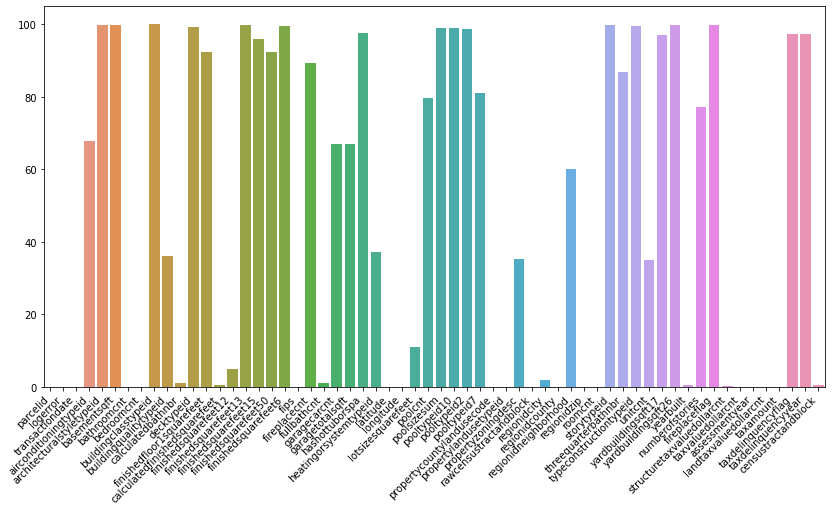

In [ ]:
fig, ax = plt.subplots(figsize=figsize)   
sns.barplot(x=missing_val.columns.tolist(), y=missing_val.iloc[0].tolist(), ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");

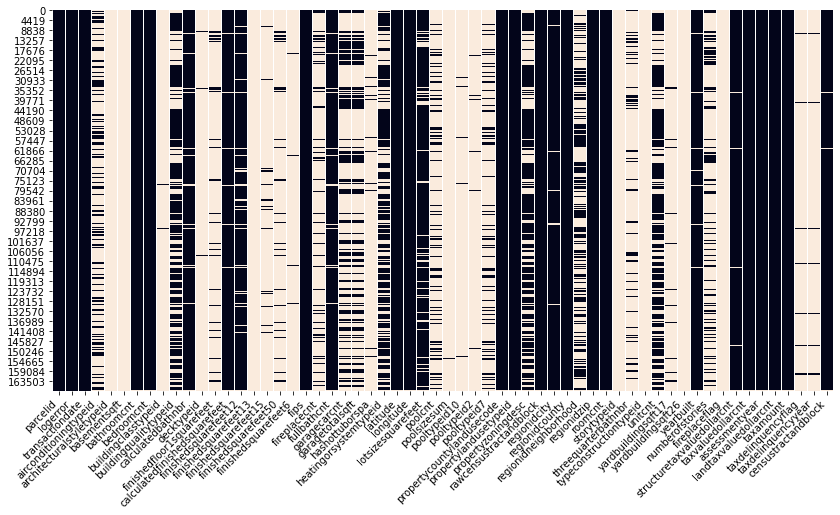

In [ ]:
fig, ax = plt.subplots(figsize=figsize)   
sns.heatmap(df.isnull(), cbar=False, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");

In [ ]:
total = data.count()
for c in missing_val.columns:
  missing_val[c] = missing_val[c]*100/total

View the columns that have the most percent of missing values. We can see that there are over 10 columns of which missing values account for > 95%

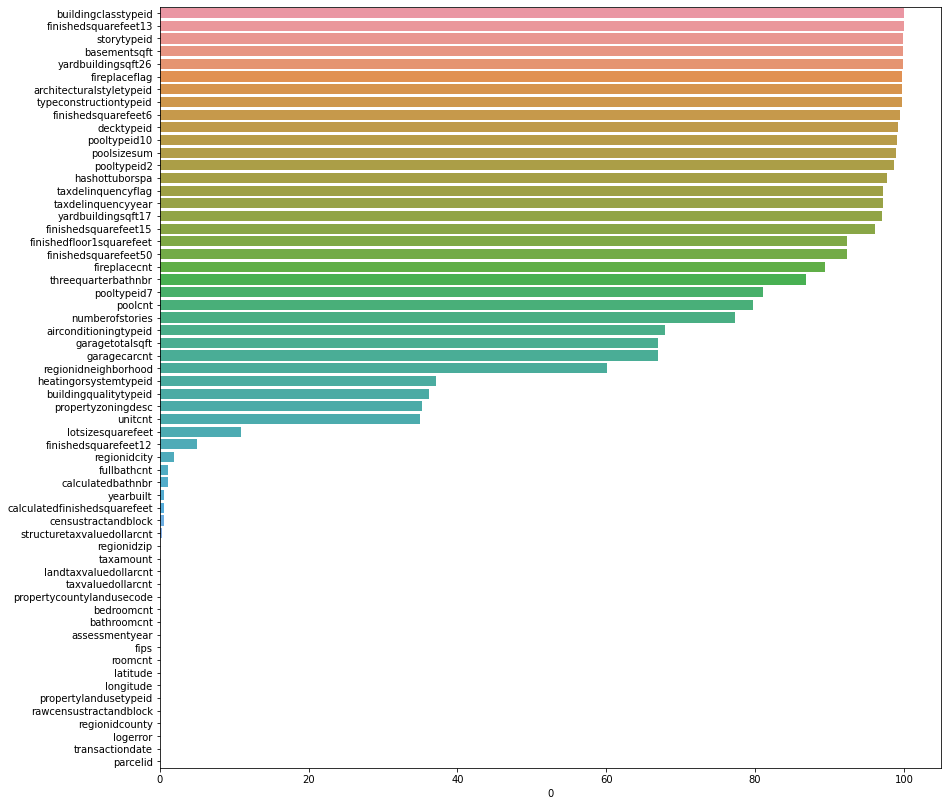

In [ ]:
missing_val = missing_val.sort_values(by=0, axis=1, ascending=False)
fig, ax = plt.subplots(figsize=(14,14))   
sns.barplot(x=missing_val.iloc[0,:], y=missing_val.columns);

## Target variable

In this part, we will focus on the target variable which is 'logerror'. 

Basic statistics of log error and its distribution will be visualized.

In [ ]:
data.describe('logerror').show()

+-------+-------------------+
|summary|           logerror|
+-------+-------------------+
|  count|             167888|
|   mean|0.01390630617124188|
| stddev|0.16570593701585137|
|    min|     -4.65542037764|
|    max|       5.2629986498|
+-------+-------------------+



Using scatter plot to find outliers:

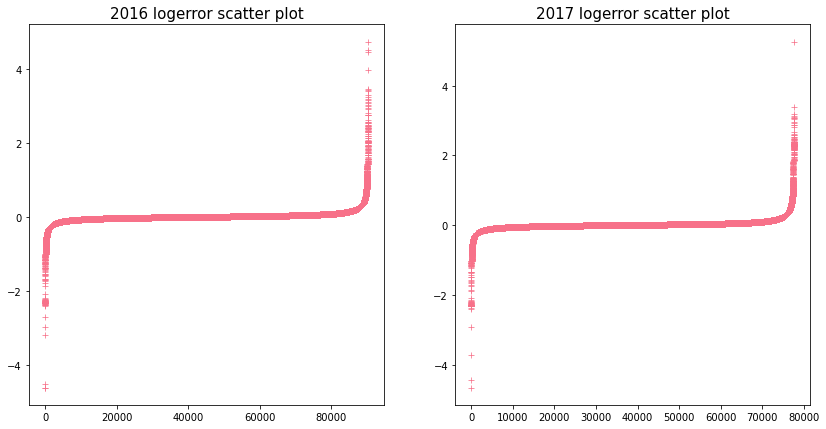

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=figsize)
sns.scatterplot(x=range(y_2016.shape[0]), y=np.sort(y_2016['logerror']), marker='+',ax=axs[0])
axs[0].set_title('2016 logerror scatter plot', size=fontsize)
sns.scatterplot(x=range(y_2017.shape[0]), y=np.sort(y_2017['logerror']), marker='+',ax=axs[1])
axs[1].set_title('2017 logerror scatter plot', size=fontsize);

For an approximately normal data set, the values within one standard deviation of the mean account for about 68% of the set; while within two standard deviations account for about 95%; and within three standard deviations account for about 99.7%. Shown percentages are rounded theoretical probabilities intended only to approximate the empirical data derived from a normal population. Using boxplot to find outliers:

In [ ]:
m16, s16 = ys_2016.select(mean(ys_2016.logerror), stddev(ys_2016.logerror)).first()
m17, s17 = ys_2017.select(mean(ys_2017.logerror), stddev(ys_2017.logerror)).first()

Logerror distribution

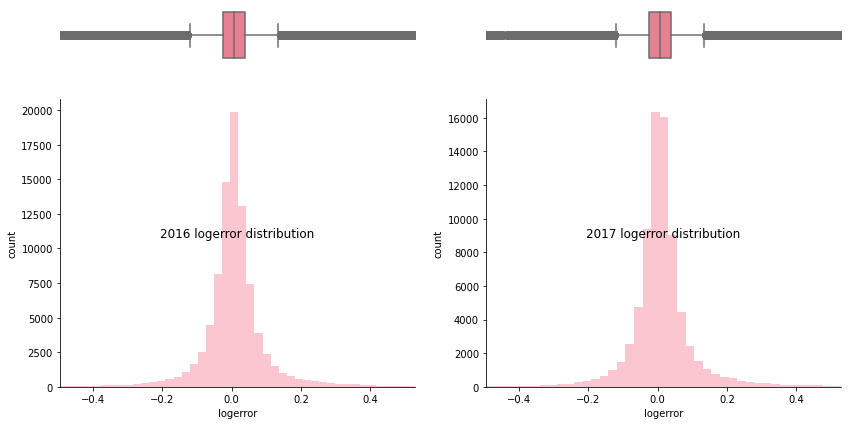

In [ ]:
fig, (ax_box, axs) = plt.subplots(ncols=2, nrows=2, figsize=figsize, sharex=True ,gridspec_kw={"height_ratios": (.1, .5)})
sns.boxplot(y_2016['logerror'],ax=ax_box[0])

sns.boxplot(y_2017['logerror'],ax=ax_box[1])
sns.distplot(y_2016['logerror'], bins=400, kde=False, ax=axs[0])
sns.distplot(y_2017['logerror'], bins=400, kde=False, ax=axs[1])

axs[0].set_xlim([m16-3*s16, m16+3*s16])
axs[1].set_xlim([m17-3*s17, m17+3*s17])

axs[0].set_ylabel('count')

axs[1].set_ylabel('count')
ax_box[0].axis('off')
sns.despine(ax=axs[0], top=True)
ax_box[1].axis('off')
sns.despine(ax=axs[1], top=True)
axs[0].set_title('2016 logerror distribution', y = 0.5)
axs[1].set_title('2017 logerror distribution', y = 0.5);

Check the transactions in each month

In [ ]:
transaction_2016 = ys_2016.withColumn('month',month(ys_2016.transactiondate)).groupBy('month').count().orderBy('month').toPandas()
transaction_2017 = ys_2017.withColumn('month',month(ys_2017.transactiondate)).groupBy('month').count().orderBy('month').toPandas()

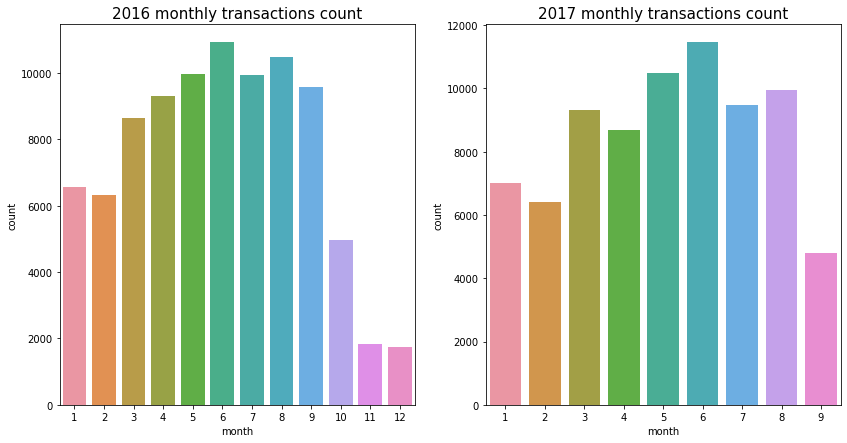

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=figsize)
sns.barplot(x = 'month', y = 'count', data = transaction_2016, ax=axs[0])
axs[0].set_title('2016 monthly transactions count', size=fontsize)
sns.barplot(x = 'month', y = 'count', data = transaction_2017, ax=axs[1])
axs[1].set_title('2017 monthly transactions count', size=fontsize);

Show average logerror by month

In [ ]:
avg_2016 = ys_2016.withColumn('month',month(ys_2016.transactiondate)).groupBy('month').agg(mean('logerror')).orderBy('month').toPandas()
avg_2017 = ys_2017.withColumn('month',month(ys_2017.transactiondate)).groupBy('month').agg(mean('logerror')).orderBy('month').toPandas()

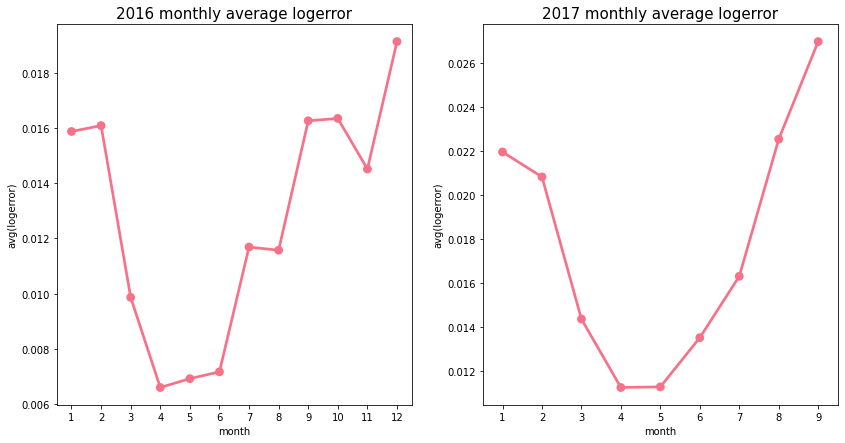

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=figsize)
sns.pointplot(x = 'month', y = 'avg(logerror)', data = avg_2016, ax=axs[0])
axs[0].set_title('2016 monthly average logerror', size=fontsize)
sns.pointplot(x = 'month', y = 'avg(logerror)', data = avg_2017, ax=axs[1])
axs[1].set_title('2017 monthly average logerror', size=fontsize);

## Data types count

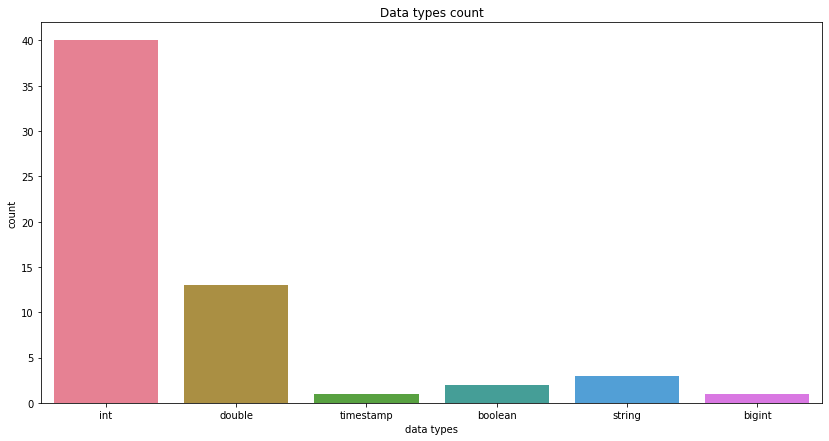

In [ ]:
dtype = Counter(t[1] for t in data.dtypes)
fig, ax = plt.subplots(figsize=figsize)   
sns.barplot(x=list(dtype.keys()), y=list(dtype.values()), ax=ax)
ax.set_title('Data types count')
ax.set_xlabel('data types')
ax.set_ylabel('count');

In [ ]:
from itertools import groupby
feature_dtype = { g : [x[0] for x in items] for g, items in groupby(sorted(data.dtypes, key=lambda x: x[1]), key=lambda x: x[1])} 
print(feature_dtype)

{'bigint': ['censustractandblock'], 'boolean': ['hashottuborspa', 'fireplaceflag'], 'double': ['logerror', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'rawcensustractandblock', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount'], 'int': ['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'buildingqualitytypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'heatingorsystemtypeid', 'latitude', 'longitude', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontyp

## Univariate analysis

**Parcelid:**

See how many times a parcel is sold

In [ ]:
data.groupBy('parcelid').agg(count('parcelid').alias('sold')).groupBy('sold').count().drop(col('parcelid')).orderBy('sold').show()

+----+------+
|sold| count|
+----+------+
|   1|162541|
|   2|  2660|
|   3|     9|
+----+------+



Frequencies of the variables with histogram plot:

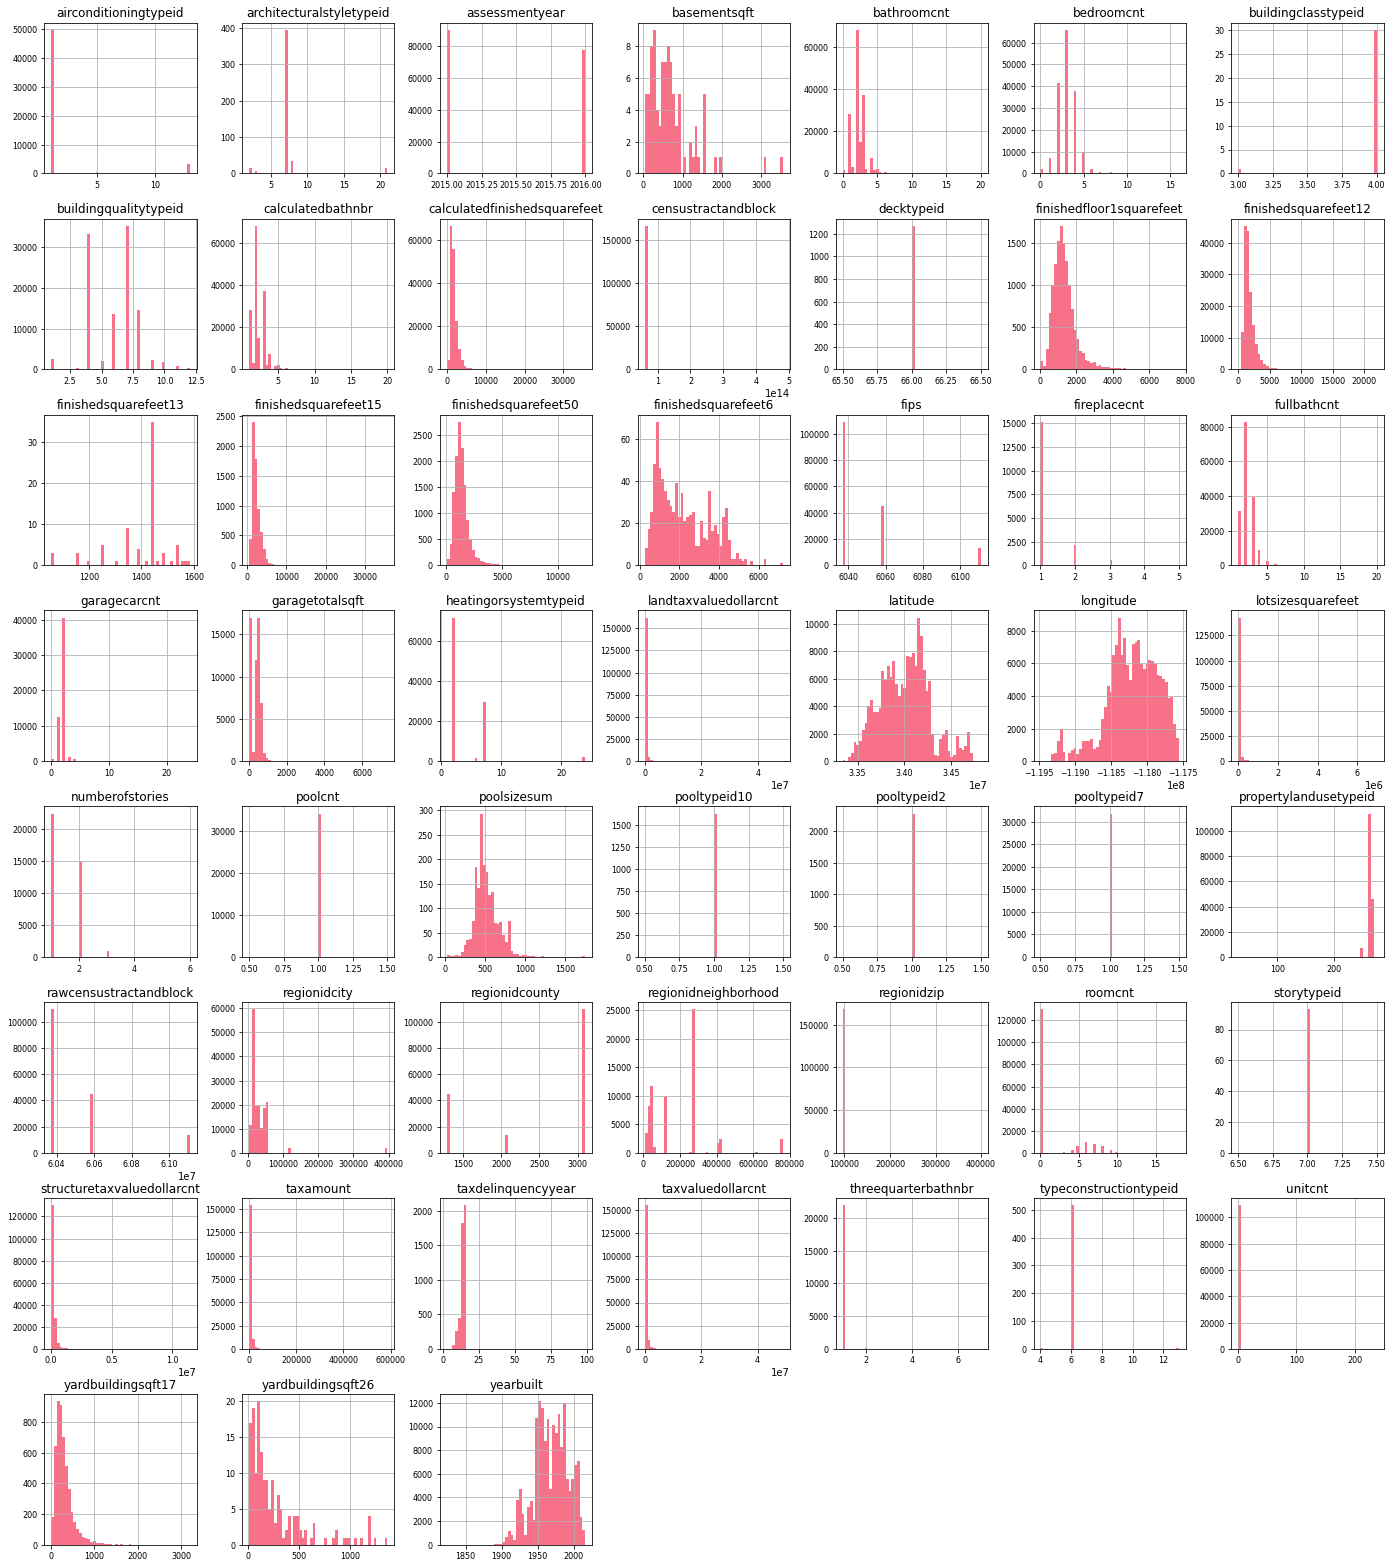

In [ ]:
df.drop(['logerror','parcelid'], axis=1).hist(figsize=(24, 28), bins=50, xlabelsize=8, ylabelsize=8);

In [ ]:
numerical = ['basementsqft', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'finishedfloor1squarefeet', 
          'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13',
          'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt',
          'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'latitude', 'longitude',
          'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'roomcnt', 'threequarterbathnbr', 'unitcnt',
          'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt', 'numberofstories',
          'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
          'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyyear']

categorical = ['airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid',
           'buildingqualitytypeid', 'decktypeid', 'fips', 'hashottuborspa', 'heatingorsystemtypeid',
           'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertycountylandusecode',
           'propertylandusetypeid', 'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
           'regionidcounty', 'regionidneighborhood', 'regionidzip', 'storytypeid',
           'typeconstructiontypeid', 'fireplaceflag', 'taxdelinquencyflag', 'censustractandblock']

### Numerical variables

Describe the descriptive statistics of each variable

In [ ]:
data.select(numerical).summary().show()

+-------+-----------------+------------------+------------------+------------------+------------------------+----------------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+------------------+------------------+------------------+-------------------+--------------------+------------------+-------+-----------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+--------------------------+------------------+-------------------+---------------------+-----------------+------------------+
|summary|     basementsqft|       bathroomcnt|        bedroomcnt| calculatedbathnbr|finishedfloor1squarefeet|calculatedfinishedsquarefeet|finishedsquarefeet12|finishedsquarefeet13|finishedsquarefeet15|finishedsquarefeet50|finishedsquarefeet6|       fireplacecnt|       fullbathcnt|      garagecarcnt|   garagetotalsqft|           latit

Distribution: skewness, kurtosis:
This subsection comes from Wikipedia Skewness.

In probability theory and statistics, skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. The skewness value can be positive or negative, or undefined.For a unimodal distribution, negative skew commonly indicates that the tail is on the left side of the distribution, and positive skew indicates that the tail is on the right.

Consider the two distributions in the figure just below. Within each graph, the values on the right side of the distribution taper differently from the values on the left side. These tapering sides are called tails, and they provide a visual means to determine which of the two kinds of skewness a distribution has:

negative skew: The left tail is longer; the mass of the distribution is concentrated on the right of the figure. The distribution is said to be left-skewed, left-tailed, or skewed to the left, despite the fact that the curve itself appears to be skewed or leaning to the right; left instead refers to the left tail being drawn out and, often, the mean being skewed to the left of a typical center of the data. A left-skewed distribution usually appears as a right-leaning curve.
positive skew: The right tail is longer; the mass of the distribution is concentrated on the left of the figure. The distribution is said to be right-skewed, right-tailed, or skewed to the right, despite the fact that the curve itself appears to be skewed or leaning to the left; right instead refers to the right tail being drawn out and, often, the mean being skewed to the right of a typical center of the data. A right-skewed distribution usually appears as a left-leaning curve.
This subsection comes from Wikipedia Kurtosis.

In probability theory and statistics, kurtosis (kyrtos or kurtos, meaning “curved, arching”) is a measure of the “tailedness” of the probability distribution of a real-valued random variable. In a similar way to the concept of skewness, kurtosis is a descriptor of the shape of a probability distribution and, just as for skewness, there are different ways of quantifying it for a theoretical distribution and corresponding ways of estimating it from a sample from a population.

In [ ]:
for col in numerical:
  data.select(skewness(col),kurtosis(col)).show()

+----------------------+----------------------+
|skewness(basementsqft)|kurtosis(basementsqft)|
+----------------------+----------------------+
|    2.2998204432196685|     7.499178459006982|
+----------------------+----------------------+

+---------------------+---------------------+
|skewness(bathroomcnt)|kurtosis(bathroomcnt)|
+---------------------+---------------------+
|    1.288622225157104|    5.605919971764951|
+---------------------+---------------------+

+--------------------+--------------------+
|skewness(bedroomcnt)|kurtosis(bedroomcnt)|
+--------------------+--------------------+
|  0.7637705126343484|   4.061907852563965|
+--------------------+--------------------+

+---------------------------+---------------------------+
|skewness(calculatedbathnbr)|kurtosis(calculatedbathnbr)|
+---------------------------+---------------------------+
|          1.458086011847979|          6.079778385865822|
+---------------------------+---------------------------+

+---------------

We can see that the most of the data is positively skewed

### Categorical variables

Frequency table

In [ ]:
window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
cate = []
for c in categorical:
  a = data.select([c,'logerror']).\
    groupBy(c).\
    agg(count('logerror').alias('logerror_num'),
        mean('logerror').alias('logerror_avg'),\
        min('logerror').alias('logerror_min'),\
        max('logerror').alias('logerror_max')).\
    withColumn('total',sum('logerror_num').over(window)).\
    withColumn('Percent',col('logerror_num')*100/col('total')).drop(col('total'))
  cate.append(a.select(c,'Percent').toPandas())
  a.show()

+---------------------+------------+--------------------+---------------+--------------+--------------------+
|airconditioningtypeid|logerror_num|        logerror_avg|   logerror_min|  logerror_max|             Percent|
+---------------------+------------+--------------------+---------------+--------------+--------------------+
|                 null|      114100| 0.01383449161546559| -4.65542037764|          4.52|   67.96197464976652|
|                    1|       49854|0.013780918195499554| -3.73701845068|  5.2629986498|  29.694796531020682|
|                   13|        3408|0.017728948946534536|         -2.688|         3.289|  2.0299247117125705|
|                    3|           1|              0.0917|         0.0917|        0.0917|5.956351853616697E-4|
|                    5|         382|0.015998849289587874|-0.597328230337| 2.31925569268| 0.22753264080815783|
|                    9|          27|-0.00741894370584...|-0.717708651785|0.893029946103| 0.01608215000476508|
|         

## Bivariate analysis

### Features vs logerror

A correlation coefficient is a way to put a value to the relationship. Correlation coefficients have a value of between -1 and 1. A “0” means there is no relationship between the variables at all, while -1 or 1 means that there is a perfect negative or positive correlation (negative or positive correlation here refers to the type of graph the relationship will produce).

We will select columns that has dtype as long, int or double and fill null with mean in order to calculate its correlation with the column 'logerror'

In [ ]:
cor_list = feature_dtype['bigint'] + feature_dtype['double'] + feature_dtype['int']

In [ ]:
df.fillna(df.mean(),inplace=True)

In [ ]:
corr = []
cor_list.remove('logerror')
for col in cor_list:
  correlation = np.corrcoef(df[col].values,df['logerror'].values)[0,1]
  if not (np.isnan(correlation)):
    corr.append((col, correlation))

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
corr = sorted(corr, key=lambda x: x[1], reverse=True)
corr

[('finishedsquarefeet12', 0.041470670292363475),
 ('calculatedfinishedsquarefeet', 0.03934368619916739),
 ('calculatedbathnbr', 0.02881442923078148),
 ('bedroomcnt', 0.028497856408140253),
 ('fullbathcnt', 0.027490214304064363),
 ('bathroomcnt', 0.02702396931722091),
 ('assessmentyear', 0.0160819484817535),
 ('garagetotalsqft', 0.016015820313916494),
 ('structuretaxvaluedollarcnt', 0.015460437361929527),
 ('garagecarcnt', 0.01489566331179247),
 ('yearbuilt', 0.01124857430871505),
 ('parcelid', 0.010730100780532725),
 ('roomcnt', 0.009944168121728892),
 ('fireplacecnt', 0.008538114448593037),
 ('basementsqft', 0.00831337240210948),
 ('threequarterbathnbr', 0.008228448215142911),
 ('lotsizesquarefeet', 0.007402113427124502),
 ('fips', 0.007402113168852917),
 ('rawcensustractandblock', 0.007370969363870675),
 ('buildingclasstypeid', 0.00653466086772048),
 ('finishedsquarefeet6', 0.006229481805355331),
 ('longitude', 0.00564083898212414),
 ('taxvaluedollarcnt', 0.00532865389059549),
 ('num

Correlation of columns with logerror

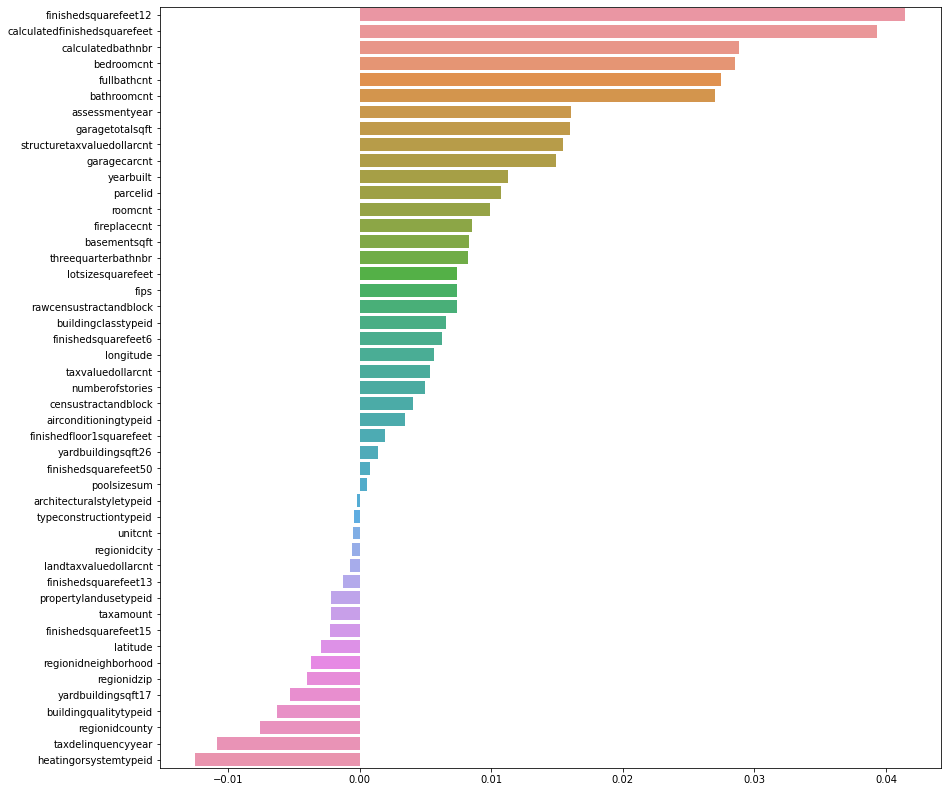

In [ ]:
fig, ax = plt.subplots(figsize=(14,14))   
sns.barplot(x=list(dict(corr).values()), y=list(dict(corr).keys()), ax=ax);

### Top features vs logerror

Select features that has strong correlations, greater than 0.02 or smaller than -0.01, respectively for positive and negative correlation

In [ ]:
top_features = [x for x in corr if x[1] > 0.02 or x[1] < -0.01]
top_features_list = dict(top_features).keys()
top_features

[('finishedsquarefeet12', 0.041470670292363475),
 ('calculatedfinishedsquarefeet', 0.03934368619916739),
 ('calculatedbathnbr', 0.02881442923078148),
 ('bedroomcnt', 0.028497856408140253),
 ('fullbathcnt', 0.027490214304064363),
 ('bathroomcnt', 0.02702396931722091),
 ('taxdelinquencyyear', -0.010870466836668875),
 ('heatingorsystemtypeid', -0.012492200828397667)]

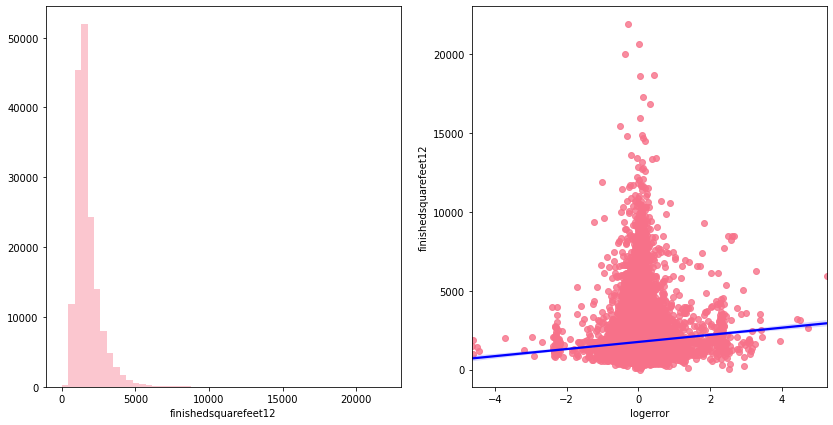

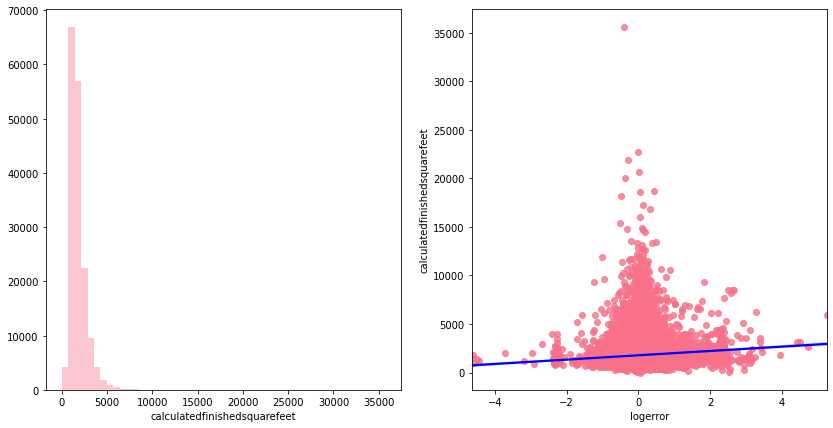

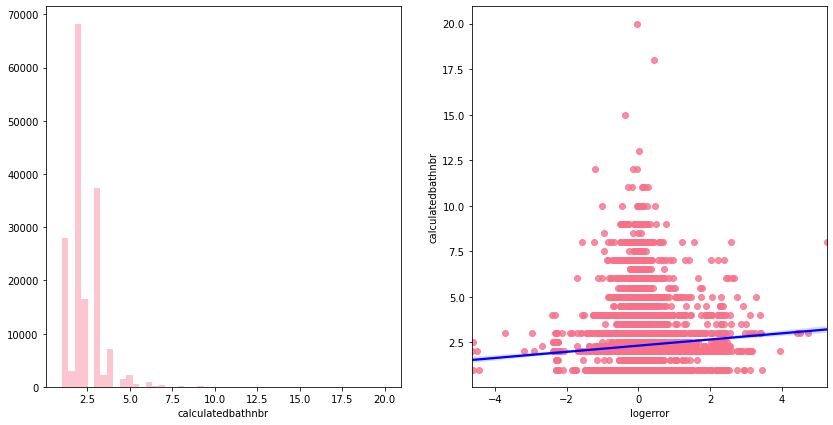

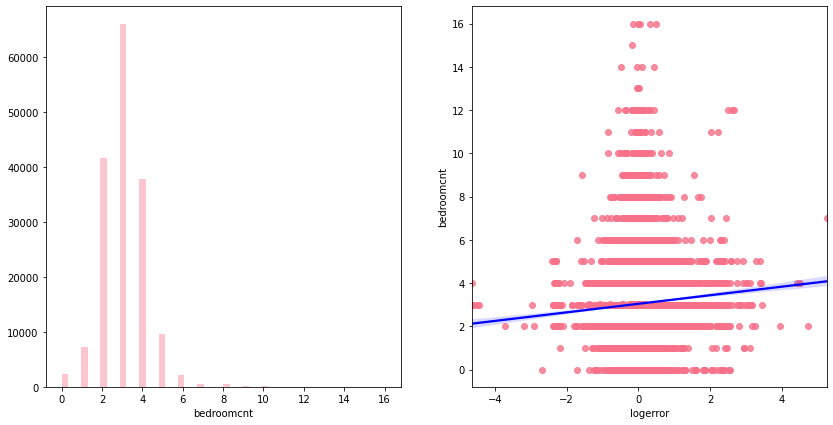

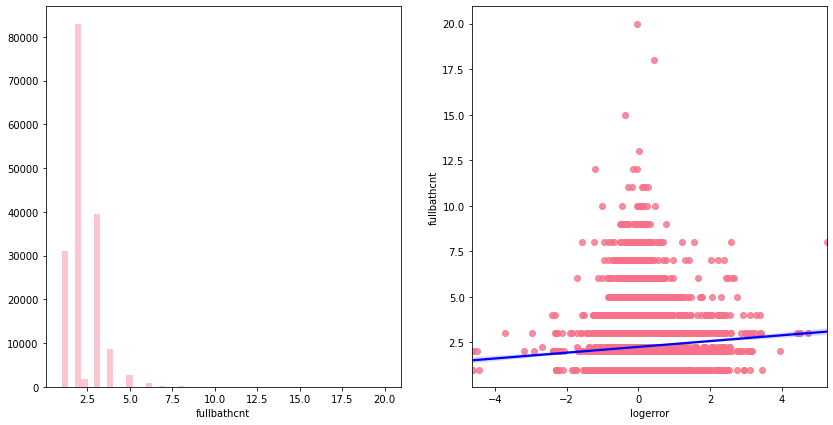

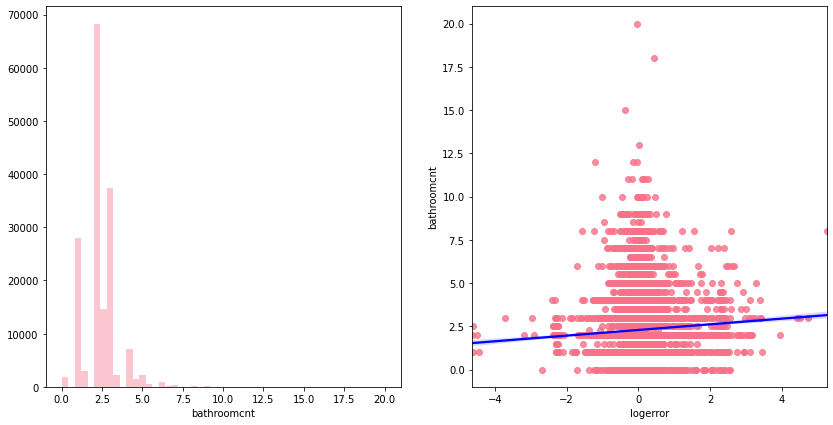

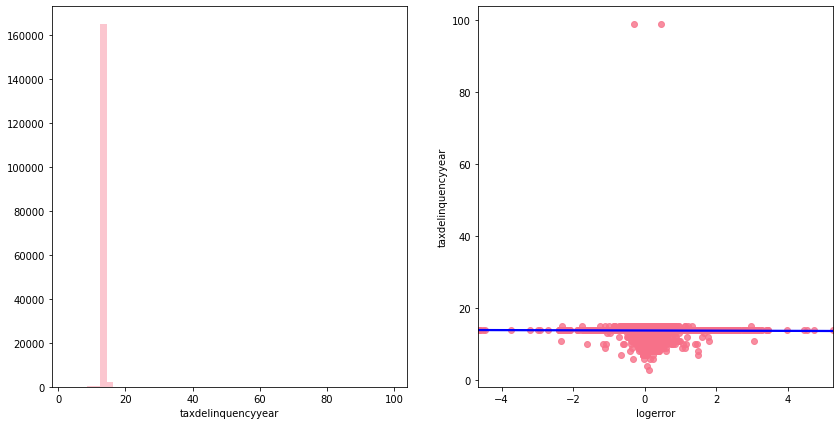

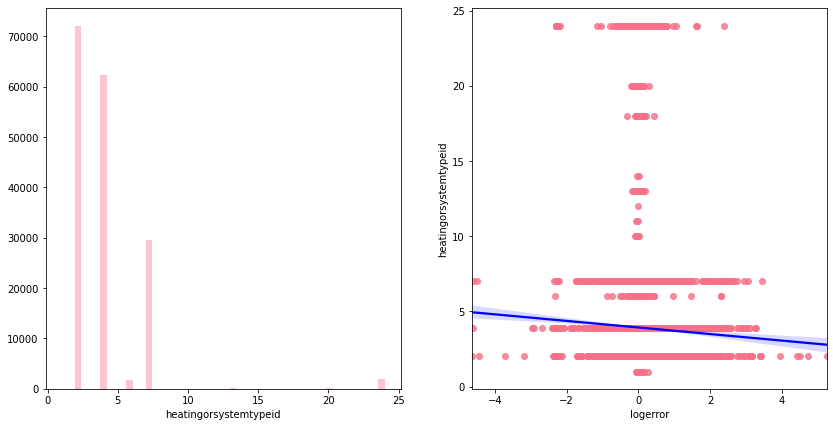

In [ ]:
for f in top_features_list:
  fig, axs = plt.subplots(ncols=2, figsize=figsize)
  sns.distplot(df[f], kde=False, ax=axs[0])
  sns.regplot(x='logerror', y=f, data=df, ax=axs[1], line_kws={"color": "blue"});

### Top features vs each other

See how intense the top features correlated with each other

In [ ]:
df_cor = df[top_features_list]
cor_matrix = df_cor.corr()
matrix = np.triu(cor_matrix)

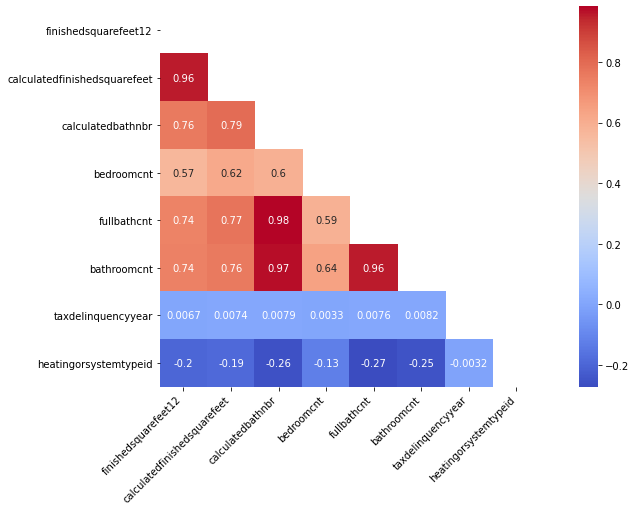

In [ ]:
fig, ax = plt.subplots(figsize=figsize)  
sns.heatmap(cor_matrix, annot=True, mask=matrix, square=True, cmap="coolwarm",ax=ax )
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");

We can see that some of the features are highly correlated, with the calculated correlation over 0.9

**calculatedfinishedsquarefeet vs finishedsquarefeet12**

**fullbathcnt vs calculatedbathnbr**

# Random Forest

In [ ]:
df = data.na.fill(0)

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
ftrs = feature_dtype['bigint'] + feature_dtype['double'] + feature_dtype['int'] + feature_dtype['boolean']
feature_list = []
for column in ftrs:
    if column == 'logerror':
        continue
    else:
        feature_list.append(column)

assembler = VectorAssembler(inputCols=feature_list, outputCol="unscaled_features", handleInvalid="keep")

In [ ]:
standardScaler = StandardScaler(inputCol="unscaled_features", outputCol="features")

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(labelCol="logerror", featuresCol="features")

In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[assembler, standardScaler, rf])

In [ ]:
(trainingData, testData) = df.randomSplit([0.7, 0.3])

In [ ]:
rf_model = pipeline.fit(trainingData)

In [ ]:
predictions = rf_model.transform(testData)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
evaluator = RegressionEvaluator(labelCol="logerror", predictionCol="prediction", metricName="mae")

score = evaluator.evaluate(predictions)

In [ ]:
print(score)

0.0690050977729337
